In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import Data

In [ ]:
url = 'https://query1.finance.yahoo.com/v7/finance/download/ICBP.JK?period1=1491177600&period2=1648944000&interval=1d&events=history&includeAdjustedClose=true'
icbp = pd.read_csv(url)
icbp['Date'] = pd.to_datetime(icbp['Date'])
icbp = icbp[~icbp.Date.duplicated()]
# icbp = icbp.set_index(['Date']).asfreq('D').fillna(method='ffill')
icbp

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-04-03,8200.0,8450.0,8200.0,8425.0,7429.060547,2068600.0
1,2017-04-04,8400.0,8425.0,8275.0,8400.0,7407.016113,3444200.0
2,2017-04-05,8400.0,8400.0,8400.0,8400.0,7407.016113,0.0
3,2017-04-06,8300.0,8325.0,8200.0,8225.0,7252.703125,10471800.0
4,2017-04-07,8200.0,8225.0,8150.0,8175.0,7208.613281,7078600.0
...,...,...,...,...,...,...,...
1255,2022-03-28,7250.0,7400.0,7200.0,7275.0,7275.000000,13828500.0
1256,2022-03-29,7300.0,7400.0,7250.0,7300.0,7300.000000,9243600.0
1257,2022-03-30,7350.0,7475.0,7325.0,7375.0,7375.000000,9768800.0
1258,2022-03-31,7400.0,7450.0,7300.0,7350.0,7350.000000,6875300.0


In [ ]:
icbp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1260 non-null   datetime64[ns]
 1   Open       1259 non-null   float64       
 2   High       1259 non-null   float64       
 3   Low        1259 non-null   float64       
 4   Close      1259 non-null   float64       
 5   Adj Close  1259 non-null   float64       
 6   Volume     1259 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 78.8 KB


In [ ]:
icbp.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,9361.119936,9453.733122,9250.734710,9352.521843,8847.075101,6.206952e+06
std,1048.674051,1057.053850,1033.571492,1046.643271,1077.616539,7.947993e+06
min,7250.000000,7400.000000,7200.000000,7250.000000,7142.479492,0.000000e+00
25%,8675.000000,8750.000000,8550.000000,8650.000000,7962.741455,2.861350e+06
50%,8900.000000,8975.000000,8800.000000,8900.000000,8550.000000,4.626600e+06
75%,10075.000000,10175.000000,9950.000000,10075.000000,9620.094727,7.381550e+06
max,12500.000000,12550.000000,12275.000000,12400.000000,11810.809570,2.044506e+08


In [ ]:
icbp['Close'].max()

12400.0

In [ ]:
icbp[icbp['Close']==icbp['Close'].max()]

,Date,Open,High,Low,Close,Adj Close,Volume
651,2019-10-08,12400.0,12400.0,12275.0,12400.0,11810.80957,2937900.0


In [ ]:
icbp[icbp['Close']==icbp['Close'].min()]

,Date,Open,High,Low,Close,Adj Close,Volume
1254,2022-03-25,7550.0,7550.0,7200.0,7250.0,7250.0,28613700.0


In [ ]:
icbp['Date'].min()

Timestamp('2017-04-03 00:00:00')

In [ ]:
# create valid date range
start = icbp['Date'].min()
end = icbp['Date'].max()

# find rows between start and end time and find the first row (00:00 monday morning)
weekly_rows = icbp[(icbp['Date'] >= start) & (icbp['Date'] <= end)].groupby([pd.Grouper(key='Date', freq='W-MON')]).first().reset_index()
weekly_rows.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-04-03,8200.0,8450.0,8200.0,8425.0,7429.060547,2068600.0
1,2017-04-10,8400.0,8425.0,8275.0,8400.0,7407.016113,3444200.0
2,2017-04-17,8200.0,8225.0,8100.0,8125.0,7164.523926,7277700.0
3,2017-04-24,8175.0,8200.0,8075.0,8200.0,7230.657715,7389500.0
4,2017-05-01,8450.0,8500.0,8375.0,8500.0,7495.194336,6203900.0


In [ ]:
weekly_rows.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
257,2022-03-07,8500.0,8525.0,8150.0,8250.0,8250.0,21470900.0
258,2022-03-14,7400.0,7600.0,7400.0,7600.0,7600.0,21825800.0
259,2022-03-21,7525.0,7600.0,7375.0,7425.0,7425.0,15064300.0
260,2022-03-28,7475.0,7600.0,7475.0,7475.0,7475.0,4588300.0
261,2022-04-04,7300.0,7400.0,7250.0,7300.0,7300.0,9243600.0


## Plotly

In [ ]:
!pip install plotly==5.6.0

In [ ]:
!pip install chart-studio

In [ ]:
from plotly import tools
import chart_studio.plotly as py
import plotly.graph_objs as go
import gc
from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)

In [ ]:
trace1 = go.Scatter(
    x = weekly_rows['Date'],
    y = weekly_rows['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = weekly_rows['Date'],
    y = weekly_rows['Close'].astype(float),
    mode = 'lines',
    name = 'Close'
)
# trace3 = go.Scatter(
#     x = weekly_rows['Date'],
#     y = weekly_rows['Adj Close'].astype(float),
#     mode = 'lines',
#     name = 'Adj Close'
# )

layout = dict(
    title='Historical ICBP Prices (2017-2022) with the Slider ',
    hovermode='x',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

# data = [trace1,trace2, trace3]
data = [trace1,trace2]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")
# fig.show()

In [ ]:
trace1 = go.Scatter(
    x = weekly_rows['Date'],
    y = weekly_rows['Volume'].astype(float),
    mode = 'lines',
    name = 'Volume'
)

layout = dict(
    title='Historical ICBP Volume (IDR) (2017-2022) with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [ ]:
trace = go.Scattergl(
    y = weekly_rows['Volume'].astype(float),
    x = weekly_rows['Close'].astype(float),
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    )
)
layout = go.Layout(
    title='ICBP Volume v/s IDR',
    xaxis=dict(
        title='Price',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Volume',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )))
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='compare_webgl')

# Eksplorasi Data

In [ ]:
icbp2 = icbp.set_index(['Date']).asfreq('D').fillna(method='ffill')

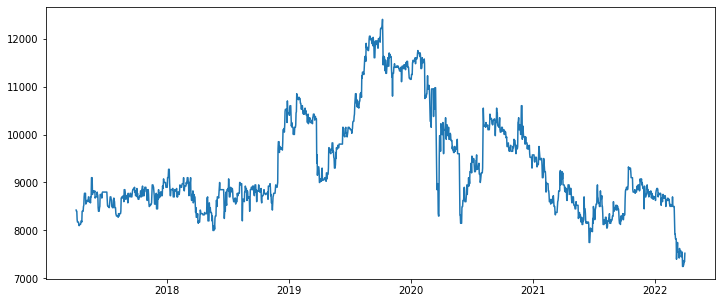

In [ ]:
ts = icbp2['Close']
plt.figure(figsize=(12,5))
plt.plot(ts)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


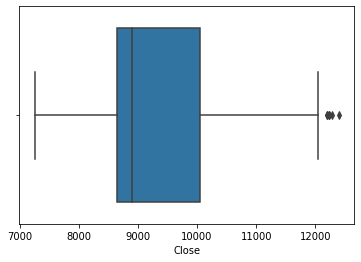

In [ ]:
sns.boxplot(ts)

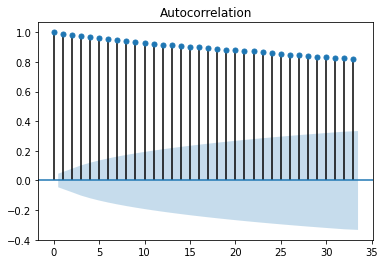

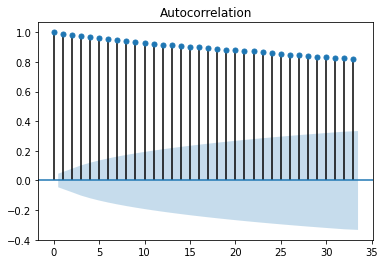

In [ ]:
plot_acf(ts)

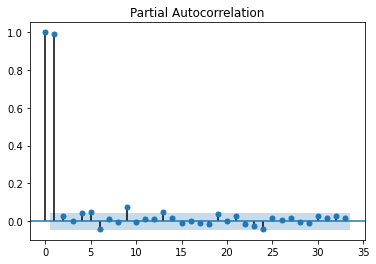

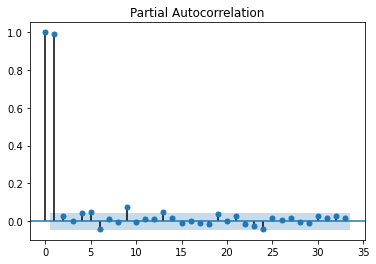

In [ ]:
plot_pacf(ts)

# Split Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def train_test_split_sequence(ts, prop_train=.8):
  split_point = round(prop_train * len(ts))
  train, test = ts[:split_point+1], ts[split_point+1:]
  return train, test

def input_output_split_sequence(seq, n_steps):
  X, y = [], []
  for i in range(len(seq)):
    end_ix = i + n_steps
    if end_ix > len(seq) - 1:
      break
    seq_x, seq_y = seq[i:end_ix], seq[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

def split_sequence(seq, n_steps=1):
  X, y = [], []
  for i in range(len(seq)-n_steps-1):
    v = seq[i:(i+n_steps), 0]
    X.append(v)
    y.append(seq[i + n_steps, 0])
  return np.array(X), np.array(y)

## Split LSTM

In [ ]:
ts = icbp2[['Close']]

ts.values

array([[8425.],
       [8400.],
       [8400.],
       ...,
       [7375.],
       [7350.],
       [7525.]])

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
ts = scaler.fit_transform(ts)

ts

array([[0.22815534],
       [0.22330097],
       [0.22330097],
       ...,
       [0.02427184],
       [0.01941748],
       [0.05339806]])

In [ ]:
ts.shape

(1825, 1)

In [ ]:
ts[7]

array([0.17961165])

#### 80:20

In [ ]:
train, test = train_test_split_sequence(ts)

output = f'''
Train: 
{train.shape}

Text:
{test.shape}
'''
print(output)


Train: 
(1461, 1)

Text:
(364, 1)



In [ ]:
X_train, y_train = split_sequence(train, n_steps=5)
X_test, y_test = split_sequence(test, n_steps=5)

output = f'''
X train ({X_train.shape}): 
{X_train}

y train ({y_train.shape}):
{y_train}
'''
print(output)


X train ((1455, 5)): 
[[0.22815534 0.22330097 0.22330097 0.18932039 0.17961165]
 [0.22330097 0.22330097 0.18932039 0.17961165 0.17961165]
 [0.22330097 0.18932039 0.17961165 0.17961165 0.17961165]
 ...
 [0.33009709 0.3592233  0.3592233  0.3592233  0.38349515]
 [0.3592233  0.3592233  0.3592233  0.38349515 0.35436893]
 [0.3592233  0.3592233  0.38349515 0.35436893 0.37864078]]

y train ((1455,)):
[0.17961165 0.17961165 0.17961165 ... 0.35436893 0.37864078 0.33009709]



In [ ]:
y_train.shape

(1455,)

In [ ]:
X_train.shape

(1455, 5)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train.shape

(1455, 1, 5)

#### 70:30

In [ ]:
train_70, test_30 = train_test_split_sequence(ts, prop_train=.7)

output = f'''
Train: 
{train_70.shape}

Text:
{test_30.shape}
'''
print(output)


Train: 
(1279, 1)

Text:
(546, 1)



In [ ]:
X_train_70, y_train_70 = split_sequence(train_70, n_steps=5)
X_test_30, y_test_30 = split_sequence(test_30, n_steps=5)

output = f'''
X train ({X_train_70.shape}): 
{X_train_70}

y train ({y_train_70.shape}):
{y_train_70}
'''
print(output)


X train ((1273, 5)): 
[[0.22815534 0.22330097 0.22330097 0.18932039 0.17961165]
 [0.22330097 0.22330097 0.18932039 0.17961165 0.17961165]
 [0.22330097 0.18932039 0.17961165 0.17961165 0.17961165]
 ...
 [0.55339806 0.54368932 0.54368932 0.54368932 0.54854369]
 [0.54368932 0.54368932 0.54368932 0.54854369 0.5631068 ]
 [0.54368932 0.54368932 0.54854369 0.5631068  0.54854369]]

y train ((1273,)):
[0.17961165 0.17961165 0.17961165 ... 0.5631068  0.54854369 0.5631068 ]



In [ ]:
y_train_70.shape

(1273,)

In [ ]:
X_train_70.shape

(1273, 5)

In [ ]:
X_train_70 = np.reshape(X_train_70, (X_train_70.shape[0], 1, X_train_70.shape[1]))
X_test_30 = np.reshape(X_test_30, (X_test_30.shape[0], 1, X_test_30.shape[1]))

In [ ]:
X_train_70.shape

(1273, 1, 5)

#### 60:40

In [ ]:
train_60, test_40 = train_test_split_sequence(ts, prop_train=.6)

output = f'''
Train: 
{train_60.shape}

Text:
{test_40.shape}
'''
print(output)


Train: 
(1096, 1)

Text:
(729, 1)



In [ ]:
X_train_60, y_train_60 = split_sequence(train_60, n_steps=5)
X_test_40, y_test_40 = split_sequence(test_40, n_steps=5)

output = f'''
X train ({X_train_60.shape}): 
{X_train_60}

y train ({y_train_60.shape}):
{y_train_60}
'''
print(output)


X train ((1090, 5)): 
[[0.22815534 0.22330097 0.22330097 0.18932039 0.17961165]
 [0.22330097 0.22330097 0.18932039 0.17961165 0.17961165]
 [0.22330097 0.18932039 0.17961165 0.17961165 0.17961165]
 ...
 [0.2038835  0.4368932  0.52912621 0.52912621 0.52912621]
 [0.4368932  0.52912621 0.52912621 0.52912621 0.46601942]
 [0.52912621 0.52912621 0.52912621 0.46601942 0.5776699 ]]

y train ((1090,)):
[0.17961165 0.17961165 0.17961165 ... 0.46601942 0.5776699  0.5631068 ]



In [ ]:
y_train_60.shape

(1090,)

In [ ]:
X_train_60.shape

(1090, 5)

In [ ]:
X_train_60 = np.reshape(X_train_60, (X_train_60.shape[0], 1, X_train_60.shape[1]))
X_test_40 = np.reshape(X_test_40, (X_test_40.shape[0], 1, X_test_40.shape[1]))

In [ ]:
X_train_60.shape

(1090, 1, 5)

## Split CNN

In [ ]:
ts2 = icbp2[['Close']]

In [ ]:
ts2

,Close
Date,
2017-04-03,8425.0
2017-04-04,8400.0
2017-04-05,8400.0
2017-04-06,8225.0
2017-04-07,8175.0
...,...
2022-03-28,7275.0
2022-03-29,7300.0
2022-03-30,7375.0


In [ ]:
ts2.shape

(1825, 1)

In [ ]:
ts2 = scaler.fit_transform(ts2)

#### 80:20

In [ ]:
train2, test2 = train_test_split_sequence(ts2)

output = f'''
Train: 
{train2}

Text:
{test2}
'''
print(output)


Train: 
[[0.22815534]
 [0.22330097]
 [0.22330097]
 ...
 [0.37864078]
 [0.33009709]
 [0.33009709]]

Text:
[[0.33009709]
 [0.33009709]
 [0.32524272]
 [0.30582524]
 [0.32038835]
 [0.30097087]
 [0.31553398]
 [0.31553398]
 [0.31553398]
 [0.27184466]
 [0.26699029]
 [0.29126214]
 [0.29126214]
 [0.33009709]
 [0.33009709]
 [0.33009709]
 [0.33009709]
 [0.32038835]
 [0.30097087]
 [0.29126214]
 [0.31553398]
 [0.31553398]
 [0.31553398]
 [0.2815534 ]
 [0.26213592]
 [0.25728155]
 [0.26699029]
 [0.2815534 ]
 [0.2815534 ]
 [0.2815534 ]
 [0.25242718]
 [0.24757282]
 [0.24757282]
 [0.24271845]
 [0.23300971]
 [0.23300971]
 [0.23300971]
 [0.26213592]
 [0.24757282]
 [0.24757282]
 [0.24757282]
 [0.24757282]
 [0.24757282]
 [0.24757282]
 [0.19417476]
 [0.2038835 ]
 [0.19902913]
 [0.2184466 ]
 [0.20873786]
 [0.20873786]
 [0.20873786]
 [0.18446602]
 [0.17961165]
 [0.17961165]
 [0.19902913]
 [0.16990291]
 [0.16990291]
 [0.16990291]
 [0.18446602]
 [0.18446602]
 [0.18932039]
 [0.2815534 ]
 [0.23300971]
 [0.23300971

In [ ]:
train2.shape

(1461, 1)

In [ ]:
X_train2, y_train2 = input_output_split_sequence(train2, n_steps=5)
X_test2, y_test2 = input_output_split_sequence(test2, n_steps=5)

output = f'''
X train ({X_train2.shape}): 
{X_train2}

y train ({y_train2.shape}):
{y_train2}
'''
print(output)


X train ((1456, 5, 1)): 
[[[0.22815534]
  [0.22330097]
  [0.22330097]
  [0.18932039]
  [0.17961165]]

 [[0.22330097]
  [0.22330097]
  [0.18932039]
  [0.17961165]
  [0.17961165]]

 [[0.22330097]
  [0.18932039]
  [0.17961165]
  [0.17961165]
  [0.17961165]]

 ...

 [[0.3592233 ]
  [0.3592233 ]
  [0.3592233 ]
  [0.38349515]
  [0.35436893]]

 [[0.3592233 ]
  [0.3592233 ]
  [0.38349515]
  [0.35436893]
  [0.37864078]]

 [[0.3592233 ]
  [0.38349515]
  [0.35436893]
  [0.37864078]
  [0.33009709]]]

y train ((1456, 1)):
[[0.17961165]
 [0.17961165]
 [0.17961165]
 ...
 [0.37864078]
 [0.33009709]
 [0.33009709]]



In [ ]:
X_train2.shape

(1456, 5, 1)

#### 70:30

In [ ]:
train2_70, test2_30 = train_test_split_sequence(ts2, prop_train=.7)

output = f'''
Train: 
{train2_70.shape}

Text:
{test2_30.shape}
'''
print(output)


Train: 
(1279, 1)

Text:
(546, 1)



In [ ]:
train2_70.shape

(1279, 1)

In [ ]:
X_train2_70, y_train2_70 = input_output_split_sequence(train2_70, n_steps=5)
X_test2_30, y_test2_30 = input_output_split_sequence(test2_30, n_steps=5)

output = f'''
X train ({X_train2_70.shape}): 
{X_train2_70}

y train ({y_train2_70.shape}):
{y_train2_70}
'''
print(output)


X train ((1274, 5, 1)): 
[[[0.22815534]
  [0.22330097]
  [0.22330097]
  [0.18932039]
  [0.17961165]]

 [[0.22330097]
  [0.22330097]
  [0.18932039]
  [0.17961165]
  [0.17961165]]

 [[0.22330097]
  [0.18932039]
  [0.17961165]
  [0.17961165]
  [0.17961165]]

 ...

 [[0.54368932]
  [0.54368932]
  [0.54368932]
  [0.54854369]
  [0.5631068 ]]

 [[0.54368932]
  [0.54368932]
  [0.54854369]
  [0.5631068 ]
  [0.54854369]]

 [[0.54368932]
  [0.54854369]
  [0.5631068 ]
  [0.54854369]
  [0.5631068 ]]]

y train ((1274, 1)):
[[0.17961165]
 [0.17961165]
 [0.17961165]
 ...
 [0.54854369]
 [0.5631068 ]
 [0.54854369]]



In [ ]:
X_train2_70.shape

(1274, 5, 1)

#### 60:40

In [ ]:
train2_60, test2_40 = train_test_split_sequence(ts2, prop_train=.6)

output = f'''
Train: 
{train2_60.shape}

Text:
{test2_40.shape}
'''
print(output)


Train: 
(1096, 1)

Text:
(729, 1)



In [ ]:
train2_60.shape

(1096, 1)

In [ ]:
train2_60.shape

(1096, 1)

In [ ]:
X_train2_60, y_train2_60 = input_output_split_sequence(train2_60, n_steps=5)
X_test2_40, y_test2_40 = input_output_split_sequence(test2_40, n_steps=5)

output = f'''
X train ({X_train2_60.shape}): 
{X_train2_60}

y train ({y_train2_60.shape}):
{y_train2_60}
'''
print(output)


X train ((1091, 5, 1)): 
[[[0.22815534]
  [0.22330097]
  [0.22330097]
  [0.18932039]
  [0.17961165]]

 [[0.22330097]
  [0.22330097]
  [0.18932039]
  [0.17961165]
  [0.17961165]]

 [[0.22330097]
  [0.18932039]
  [0.17961165]
  [0.17961165]
  [0.17961165]]

 ...

 [[0.4368932 ]
  [0.52912621]
  [0.52912621]
  [0.52912621]
  [0.46601942]]

 [[0.52912621]
  [0.52912621]
  [0.52912621]
  [0.46601942]
  [0.5776699 ]]

 [[0.52912621]
  [0.52912621]
  [0.46601942]
  [0.5776699 ]
  [0.5631068 ]]]

y train ((1091, 1)):
[[0.17961165]
 [0.17961165]
 [0.17961165]
 ...
 [0.5776699 ]
 [0.5631068 ]
 [0.57281553]]



In [ ]:
X_train2_60.shape

(1091, 5, 1)

# Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
# from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 5.4 MB/s 


In [ ]:
import keras_tuner as kt

## Vanilla LSTM

### Model

In [ ]:
def model_builder(hp):
  model = Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units_lstm = hp.Int('units_lstm', min_value=32, max_value=512, step=32)
  model.add(LSTM(hp_units_lstm, activation='relu', input_shape=(1, 5)))
  model.add(Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mse')

  return model

In [ ]:
tuner = kt.RandomSearch(model_builder,
                     objective='val_loss',
                     max_trials=15,
                     seed=42,
                     executions_per_trial=2,
                     directory='/content/drive/MyDrive/Skripsweet/mse/icbp',
                     project_name='vanilla-lstm'
                    # # FOR TRAIN ONLY
                    #  overwrite=True
                    # # --------------
                     )

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Skripsweet/mse/icbp/vanilla-lstm/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Skripsweet/mse/icbp/vanilla-lstm/tuner0.json


In [ ]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

tuning = ['units_lstm', 'learning_rate']
print('Best tune:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune:
units_lstm: 416
learning_rate: 0.01


In [ ]:
tuner.results_summary(num_trials=15)

Results summary
Results in /content/drive/MyDrive/Skripsweet/mse/icbp/vanilla-lstm
Showing 15 best trials
Trial summary
Hyperparameters:
units_lstm: 416
learning_rate: 0.01
Score: 0.0006290480960160494
Trial summary
Hyperparameters:
units_lstm: 288
learning_rate: 0.01
Score: 0.0006307681032922119
Trial summary
Hyperparameters:
units_lstm: 320
learning_rate: 0.01
Score: 0.0006308612937573344
Trial summary
Hyperparameters:
units_lstm: 256
learning_rate: 0.01
Score: 0.0006334111385513097
Trial summary
Hyperparameters:
units_lstm: 480
learning_rate: 0.01
Score: 0.0006337461236398667
Trial summary
Hyperparameters:
units_lstm: 352
learning_rate: 0.01
Score: 0.0006349830946419388
Trial summary
Hyperparameters:
units_lstm: 64
learning_rate: 0.01
Score: 0.0006434762908611447
Trial summary
Hyperparameters:
units_lstm: 192
learning_rate: 0.001
Score: 0.0006800858827773482
Trial summary
Hyperparameters:
units_lstm: 480
learning_rate: 0.001
Score: 0.0006812568753957748
Trial summary
Hyperparameters

#### 80:20

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
lstm = tuner.hypermodel.build(best_hp)

lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 416)               702208    
                                                                 
 dense_1 (Dense)             (None, 1)                 417       
                                                                 
Total params: 702,625
Trainable params: 702,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historylstm = lstm.fit(X_train, y_train,
                       epochs=50,
                       validation_data=(X_test, y_test), 
                       verbose=2)

Epoch 1/50
46/46 - 6s - loss: 0.0166 - val_loss: 0.0013 - 6s/epoch - 120ms/step
Epoch 2/50
46/46 - 2s - loss: 0.0014 - val_loss: 9.2040e-04 - 2s/epoch - 33ms/step
Epoch 3/50
46/46 - 1s - loss: 0.0013 - val_loss: 9.2218e-04 - 1s/epoch - 29ms/step
Epoch 4/50
46/46 - 1s - loss: 0.0012 - val_loss: 7.6794e-04 - 1s/epoch - 23ms/step
Epoch 5/50
46/46 - 1s - loss: 0.0011 - val_loss: 7.7505e-04 - 975ms/epoch - 21ms/step
Epoch 6/50
46/46 - 1s - loss: 0.0011 - val_loss: 8.6095e-04 - 1s/epoch - 23ms/step
Epoch 7/50
46/46 - 1s - loss: 0.0010 - val_loss: 5.5820e-04 - 1s/epoch - 23ms/step
Epoch 8/50
46/46 - 1s - loss: 8.7148e-04 - val_loss: 6.0726e-04 - 1s/epoch - 23ms/step
Epoch 9/50
46/46 - 1s - loss: 8.9572e-04 - val_loss: 5.1216e-04 - 962ms/epoch - 21ms/step
Epoch 10/50
46/46 - 1s - loss: 8.6378e-04 - val_loss: 5.5961e-04 - 1s/epoch - 24ms/step
Epoch 11/50
46/46 - 1s - loss: 7.7762e-04 - val_loss: 4.7209e-04 - 1s/epoch - 22ms/step
Epoch 12/50
46/46 - 2s - loss: 8.5489e-04 - val_loss: 4.6199e-04 -

In [ ]:
lstm.save('vanilla_lstm.h5')

#### 70:30

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
lstm7030 = tuner.hypermodel.build(best_hp)

lstm7030.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 416)               702208    
                                                                 
 dense_2 (Dense)             (None, 1)                 417       
                                                                 
Total params: 702,625
Trainable params: 702,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historylstm7030 = lstm7030.fit(X_train_70, y_train_70,
                       epochs=50,
                       validation_data=(X_test_30, y_test_30), 
                       verbose=2)

Epoch 1/50
40/40 - 2s - loss: 0.0231 - val_loss: 0.0033 - 2s/epoch - 60ms/step
Epoch 2/50
40/40 - 1s - loss: 0.0017 - val_loss: 9.1767e-04 - 552ms/epoch - 14ms/step
Epoch 3/50
40/40 - 1s - loss: 0.0015 - val_loss: 9.0215e-04 - 541ms/epoch - 14ms/step
Epoch 4/50
40/40 - 1s - loss: 0.0014 - val_loss: 8.5920e-04 - 584ms/epoch - 15ms/step
Epoch 5/50
40/40 - 1s - loss: 0.0013 - val_loss: 8.4321e-04 - 569ms/epoch - 14ms/step
Epoch 6/50
40/40 - 1s - loss: 0.0013 - val_loss: 7.5398e-04 - 635ms/epoch - 16ms/step
Epoch 7/50
40/40 - 1s - loss: 0.0013 - val_loss: 7.0235e-04 - 620ms/epoch - 15ms/step
Epoch 8/50
40/40 - 1s - loss: 0.0011 - val_loss: 6.6086e-04 - 695ms/epoch - 17ms/step
Epoch 9/50
40/40 - 1s - loss: 0.0011 - val_loss: 6.7528e-04 - 690ms/epoch - 17ms/step
Epoch 10/50
40/40 - 1s - loss: 0.0010 - val_loss: 7.4980e-04 - 704ms/epoch - 18ms/step
Epoch 11/50
40/40 - 1s - loss: 9.7549e-04 - val_loss: 6.9155e-04 - 659ms/epoch - 16ms/step
Epoch 12/50
40/40 - 1s - loss: 0.0010 - val_loss: 6.770

In [ ]:
lstm7030.save('vanilla_lstm7030.h5')

#### 60:40

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
lstm6040 = tuner.hypermodel.build(best_hp)

lstm6040.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 416)               702208    
                                                                 
 dense_3 (Dense)             (None, 1)                 417       
                                                                 
Total params: 702,625
Trainable params: 702,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historylstm6040 = lstm6040.fit(X_train_60, y_train_60,
                       epochs=50,
                       validation_data=(X_test_40, y_test_40), 
                       verbose=2)

Epoch 1/50
35/35 - 3s - loss: 0.0267 - val_loss: 0.0019 - 3s/epoch - 78ms/step
Epoch 2/50
35/35 - 1s - loss: 0.0017 - val_loss: 0.0013 - 598ms/epoch - 17ms/step
Epoch 3/50
35/35 - 1s - loss: 0.0014 - val_loss: 0.0012 - 550ms/epoch - 16ms/step
Epoch 4/50
35/35 - 1s - loss: 0.0014 - val_loss: 0.0011 - 594ms/epoch - 17ms/step
Epoch 5/50
35/35 - 1s - loss: 0.0014 - val_loss: 0.0011 - 562ms/epoch - 16ms/step
Epoch 6/50
35/35 - 1s - loss: 0.0014 - val_loss: 9.8483e-04 - 583ms/epoch - 17ms/step
Epoch 7/50
35/35 - 1s - loss: 0.0012 - val_loss: 0.0010 - 630ms/epoch - 18ms/step
Epoch 8/50
35/35 - 1s - loss: 0.0011 - val_loss: 8.1455e-04 - 539ms/epoch - 15ms/step
Epoch 9/50
35/35 - 1s - loss: 9.8519e-04 - val_loss: 7.9634e-04 - 580ms/epoch - 17ms/step
Epoch 10/50
35/35 - 1s - loss: 9.4536e-04 - val_loss: 9.4886e-04 - 547ms/epoch - 16ms/step
Epoch 11/50
35/35 - 1s - loss: 8.4985e-04 - val_loss: 7.1539e-04 - 557ms/epoch - 16ms/step
Epoch 12/50
35/35 - 1s - loss: 8.4530e-04 - val_loss: 6.6553e-04 - 

In [ ]:
lstm6040.save('vanilla_lstm6040.h5')

### Evaluation

In [ ]:
from keras.models import load_model

lstm = load_model("/content/drive/MyDrive/Skripsweet/mse/vanilla_lstm/vanilla_lstm.h5")
lstm7030 = load_model("/content/drive/MyDrive/Skripsweet/mse/vanilla_lstm/vanilla_lstm7030.h5")
lstm6040 = load_model("/content/drive/MyDrive/Skripsweet/mse/vanilla_lstm/vanilla_lstm6040.h5")

In [ ]:
def metrics_evaluation_regression(test, predict):
  metrics = pd.DataFrame({
      'R2': [r2_score(test, predict)],
      'MSE': [mean_squared_error(test, predict)],
      'RMSE': [np.sqrt(mean_squared_error(test, predict))],
      'MAE': [mean_absolute_error(test, predict)],
      'MAPE': [mean_absolute_percentage_error(test, predict)]
  })
  return metrics

80:20

In [ ]:
train_predict = lstm.predict(X_train)
test_predict = lstm.predict(X_test)

In [ ]:
metrics_evaluation_regression(y_train, train_predict)

,R2,MSE,RMSE,MAE,MAPE
0,0.982747,0.000702,0.02649,0.016287,0.043868


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([y_test])

In [ ]:
metrics_evaluation_regression(train_y[0], train_predict)

,R2,MSE,RMSE,MAE,MAPE
0,0.982747,18611.666712,136.424583,83.880365,0.008853


In [ ]:
metrics_evaluation_regression(test_y[0], test_predict)

,R2,MSE,RMSE,MAE,MAPE
0,0.878271,20614.853753,143.578737,98.685308,0.01203


70:30

In [ ]:
train_predict_70 = lstm7030.predict(X_train_70)
test_predict_30 = lstm7030.predict(X_test_30)

In [ ]:
metrics_evaluation_regression(y_train_70, train_predict_70)

,R2,MSE,RMSE,MAE,MAPE
0,0.984531,0.000694,0.026347,0.014908,0.039269


In [ ]:
train_predict_70 = scaler.inverse_transform(train_predict_70)
train_y_70 = scaler.inverse_transform([y_train_70])
test_predict_30 = scaler.inverse_transform(test_predict_30)
test_y_30 = scaler.inverse_transform([y_test_30])

In [ ]:
metrics_evaluation_regression(train_y_70[0], train_predict_70)

,R2,MSE,RMSE,MAE,MAPE
0,0.984531,18410.96244,135.687002,76.775485,0.008052


In [ ]:
metrics_evaluation_regression(test_y_30[0], test_predict_30)

,R2,MSE,RMSE,MAE,MAPE
0,0.963433,14468.060073,120.283249,75.43124,0.008753


60:40

In [ ]:
train_predict_60 = lstm6040.predict(X_train_60)
test_predict_40 = lstm6040.predict(X_test_40)

In [ ]:
metrics_evaluation_regression(y_train_60, train_predict_60)

,R2,MSE,RMSE,MAE,MAPE
0,0.985983,0.000703,0.026516,0.017003,0.046476


In [ ]:
train_predict_60 = scaler.inverse_transform(train_predict_60)
train_y_60 = scaler.inverse_transform([y_train_60])
test_predict_40 = scaler.inverse_transform(test_predict_40)
test_y_40 = scaler.inverse_transform([y_test_40])

In [ ]:
metrics_evaluation_regression(train_y_60[0], train_predict_60)

,R2,MSE,RMSE,MAE,MAPE
0,0.985983,18647.294431,136.555097,87.563193,0.009223


In [ ]:
metrics_evaluation_regression(test_y_40[0], test_predict_40)

,R2,MSE,RMSE,MAE,MAPE
0,0.96434,18719.713408,136.820004,96.056766,0.010775


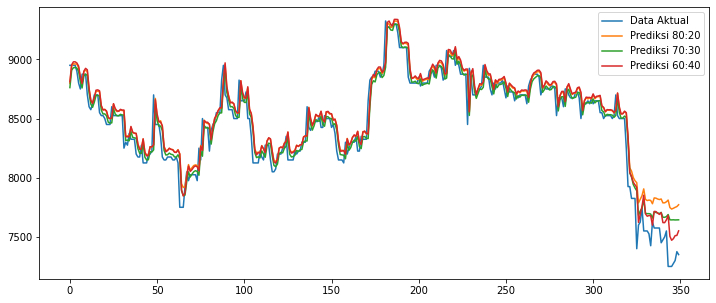

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[0][-350:])
plt.plot(test_predict[-350:])
plt.plot(test_predict_30[-350:])
plt.plot(test_predict_40[-350:])
plt.legend(['Data Aktual', 'Prediksi 80:20', 'Prediksi 70:30', 'Prediksi 60:40'])

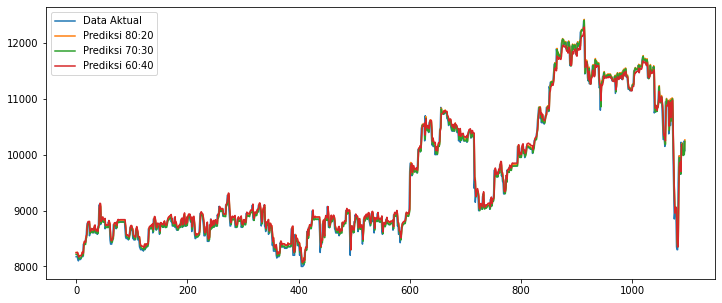

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_y[0][:1096])
plt.plot(train_predict[:1096])
plt.plot(train_predict_70[:1096])
plt.plot(train_predict_60)
plt.legend(['Data Aktual', 'Prediksi 80:20', 'Prediksi 70:30', 'Prediksi 60:40'])

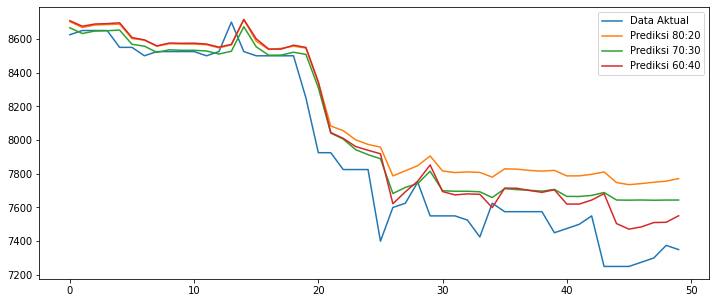

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[0][-50:])
plt.plot(test_predict[-50:])
plt.plot(test_predict_30[-50:])
plt.plot(test_predict_40[-50:])
plt.legend(['Data Aktual', 'Prediksi 80:20', 'Prediksi 70:30', 'Prediksi 60:40'])

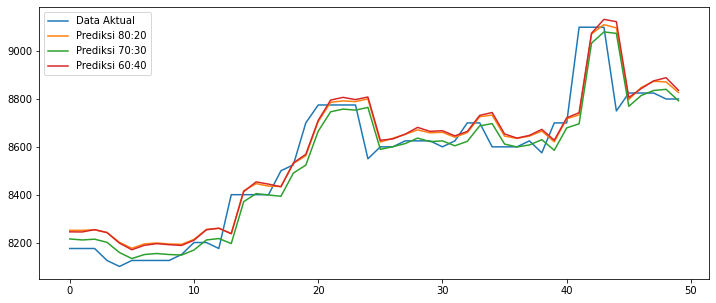

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_y[0][:50])
plt.plot(train_predict[:50])
plt.plot(train_predict_70[:50])
plt.plot(train_predict_60[:50])
plt.legend(['Data Aktual', 'Prediksi 80:20', 'Prediksi 70:30', 'Prediksi 60:40'])

## CNN-LSTM

### Model

In [ ]:
def cnnlstm_builder(hp):
  n_steps, n_features = 5, 1
  model = Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_filter = hp.Int('units_filter', min_value=32, max_value=512, step=32)
  hp_units_lstm = hp.Int('units_lstm', min_value=32, max_value=512, step=32)
  model.add(Reshape((n_steps, n_features), input_dim=n_steps))
  model.add(Conv1D(filters=hp_filter, kernel_size=2, activation='relu'))
  model.add(LSTM(hp_units_lstm, activation='relu'))
  model.add(Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mse')

  return model

In [ ]:
cnntuner = kt.RandomSearch(cnnlstm_builder,
                     objective='val_loss',
                     max_trials=15,
                     seed=42,
                     executions_per_trial=2,
                     directory='/content/drive/MyDrive/Skripsweet/mse/icbp',
                    #  overwrite=True,
                     project_name='cnn-lstm'
                    # # FOR TRAIN ONLY
                    # # --------------
                     )

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Skripsweet/mse/icbp/cnn-lstm/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Skripsweet/mse/icbp/cnn-lstm/tuner0.json


In [ ]:
cnntuner.search(X_train2, y_train2, epochs=50, validation_split=0.2)

Trial 15 Complete [00h 01m 23s]
val_loss: 0.0006353243952617049

Best val_loss So Far: 0.0006181939388625324
Total elapsed time: 00h 31m 15s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hps=cnntuner.get_best_hyperparameters(num_trials=1)[0]

tuning = ['units_lstm', 'learning_rate', 'units_filter']
print('Best tune:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune:
units_lstm: 256
learning_rate: 0.001
units_filter: 256


In [ ]:
cnntuner.results_summary(num_trials=15)

Results summary
Results in icbp/cnn-lstm
Showing 15 best trials
Trial summary
Hyperparameters:
units_filter: 256
units_lstm: 256
learning_rate: 0.001
Score: 0.0006181939388625324
Trial summary
Hyperparameters:
units_filter: 160
units_lstm: 448
learning_rate: 0.001
Score: 0.000619336060481146
Trial summary
Hyperparameters:
units_filter: 352
units_lstm: 480
learning_rate: 0.001
Score: 0.0006210983847267926
Trial summary
Hyperparameters:
units_filter: 256
units_lstm: 224
learning_rate: 0.001
Score: 0.000621594866970554
Trial summary
Hyperparameters:
units_filter: 288
units_lstm: 96
learning_rate: 0.001
Score: 0.0006260968802962452
Trial summary
Hyperparameters:
units_filter: 64
units_lstm: 320
learning_rate: 0.01
Score: 0.0006280881643760949
Trial summary
Hyperparameters:
units_filter: 416
units_lstm: 96
learning_rate: 0.001
Score: 0.0006293899787124246
Trial summary
Hyperparameters:
units_filter: 352
units_lstm: 64
learning_rate: 0.001
Score: 0.0006301785761024803
Trial summary
Hyperpara

#### 80:20

In [ ]:
best_hp = cnntuner.get_best_hyperparameters()[0]
lstmcnn = cnntuner.hypermodel.build(best_hp)

lstmcnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 5, 1)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 256)            768       
                                                                 
 lstm_5 (LSTM)               (None, 256)               525312    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 526,337
Trainable params: 526,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historylstmncnn = lstmcnn.fit(X_train2, y_train2, epochs=50, validation_data=(X_test2, y_test2))

Epoch 1/50
46/46 [==============================] - 4s 45ms/step - loss: 0.0267 - val_loss: 0.0016
Epoch 2/50
46/46 [==============================] - 2s 38ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/50
46/46 [==============================] - 2s 35ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/50
46/46 [==============================] - 2s 37ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 5/50
46/46 [==============================] - 2s 36ms/step - loss: 0.0013 - val_loss: 8.9542e-04
Epoch 6/50
46/46 [==============================] - 2s 35ms/step - loss: 0.0012 - val_loss: 9.5849e-04
Epoch 7/50
46/46 [==============================] - 2s 39ms/step - loss: 0.0012 - val_loss: 7.9367e-04
Epoch 8/50
46/46 [==============================] - 2s 38ms/step - loss: 0.0012 - val_loss: 7.1089e-04
Epoch 9/50
46/46 [==============================] - 2s 37ms/step - loss: 0.0011 - val_loss: 9.5027e-04
Epoch 10/50
46/46 [==============================] - 2s 35ms/step - loss: 0.0012 - val_lo

In [ ]:
lstmcnn.save('cnn_lstm.h5')

#### 70:30

In [ ]:
best_hp = cnntuner.get_best_hyperparameters()[0]
lstmcnn7030 = cnntuner.hypermodel.build(best_hp)

lstmcnn7030.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 5, 1)              0         
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 256)            768       
                                                                 
 lstm_6 (LSTM)               (None, 256)               525312    
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 526,337
Trainable params: 526,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historylstmncnn7030 = lstmcnn7030.fit(X_train2_70, y_train2_70, 
                                  epochs=50, 
                                  validation_data=(X_test2_30, y_test2_30))

Epoch 1/50
40/40 [==============================] - 4s 46ms/step - loss: 0.0362 - val_loss: 0.0029
Epoch 2/50
40/40 [==============================] - 2s 38ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 3/50
40/40 [==============================] - 1s 37ms/step - loss: 0.0015 - val_loss: 9.9239e-04
Epoch 4/50
40/40 [==============================] - 2s 54ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/50
40/40 [==============================] - 2s 40ms/step - loss: 0.0015 - val_loss: 9.5412e-04
Epoch 6/50
40/40 [==============================] - 2s 43ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 7/50
40/40 [==============================] - 2s 38ms/step - loss: 0.0014 - val_loss: 8.8368e-04
Epoch 8/50
40/40 [==============================] - 2s 39ms/step - loss: 0.0013 - val_loss: 9.2556e-04
Epoch 9/50
40/40 [==============================] - 2s 43ms/step - loss: 0.0013 - val_loss: 8.9989e-04
Epoch 10/50
40/40 [==============================] - 2s 41ms/step - loss: 0.0014 - val_lo

In [ ]:
lstmcnn7030.save('cnn_lstm7030.h5')

#### 60:40

In [ ]:
best_hp = cnntuner.get_best_hyperparameters()[0]
lstmcnn6040 = cnntuner.hypermodel.build(best_hp)

lstmcnn6040.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 5, 1)              0         
                                                                 
 conv1d_3 (Conv1D)           (None, 4, 256)            768       
                                                                 
 lstm_7 (LSTM)               (None, 256)               525312    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 526,337
Trainable params: 526,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historylstmncnn6040 = lstmcnn6040.fit(X_train2_60, y_train2_60, 
                                      epochs=50, 
                                      validation_data=(X_test2_40, y_test2_40))

Epoch 1/50
35/35 [==============================] - 4s 51ms/step - loss: 0.0446 - val_loss: 0.0052
Epoch 2/50
35/35 [==============================] - 1s 40ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 3/50
35/35 [==============================] - 1s 40ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/50
35/35 [==============================] - 1s 40ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/50
35/35 [==============================] - 2s 45ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/50
35/35 [==============================] - 1s 41ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/50
35/35 [==============================] - 2s 43ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/50
35/35 [==============================] - 1s 42ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/50
35/35 [==============================] - 1s 40ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/50
35/35 [==============================] - 1s 40ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 11/

In [ ]:
lstmcnn6040.save('cnn_lstm6040.h5')

### Evaluation

In [ ]:
def metrics_evaluation_regression(test, predict):
  metrics = pd.DataFrame({
      'R2': [r2_score(test, predict)],
      'MSE': [mean_squared_error(test, predict)],
      'RMSE': [np.sqrt(mean_squared_error(test, predict))],
      'MAE': [mean_absolute_error(test, predict)],
      'MAPE': [mean_absolute_percentage_error(test, predict)]
  })
  return metrics

In [ ]:
from keras.models import load_model

lstmcnn = load_model("/content/drive/MyDrive/Skripsweet/mse/cnn_lstm/cnn_lstm.h5")
lstmcnn7030 = load_model("/content/drive/MyDrive/Skripsweet/mse/cnn_lstm/cnn_lstm7030.h5")
lstmcnn6040 = load_model("/content/drive/MyDrive/Skripsweet/mse/cnn_lstm/cnn_lstm6040.h5")

80:20

In [ ]:
cnn_train = lstmcnn.predict(X_train2)
cnn_test = lstmcnn.predict(X_test2)

In [ ]:
metrics_evaluation_regression(y_train2, cnn_train)

,R2,MSE,RMSE,MAE,MAPE
0,0.979118,0.000849,0.029137,0.020072,0.047013


In [ ]:
cnn_train = scaler.inverse_transform(cnn_train)
train_y = scaler.inverse_transform(y_train2)
cnn_test = scaler.inverse_transform(cnn_test)
test_y = scaler.inverse_transform(y_test2)

In [ ]:
metrics_evaluation_regression(train_y, cnn_train)

,R2,MSE,RMSE,MAE,MAPE
0,0.979118,22516.082201,150.053598,103.368919,0.010558


In [ ]:
metrics_evaluation_regression(test_y, cnn_test)

,R2,MSE,RMSE,MAE,MAPE
0,0.924641,12919.45148,113.663765,75.197576,0.009023


70:30

In [ ]:
cnn_train_70 = lstmcnn7030.predict(X_train2_70)
cnn_test_30 = lstmcnn7030.predict(X_test2_30)

In [ ]:
metrics_evaluation_regression(y_train2_70, cnn_train_70)

,R2,MSE,RMSE,MAE,MAPE
0,0.983714,0.00073,0.027025,0.016335,0.040908


In [ ]:
cnn_train_70 = scaler.inverse_transform(cnn_train_70)
train_y_70 = scaler.inverse_transform(y_train2_70)
cnn_test_30 = scaler.inverse_transform(cnn_test_30)
test_y_30 = scaler.inverse_transform(y_test2_30)

In [ ]:
metrics_evaluation_regression(train_y_70, cnn_train_70)

,R2,MSE,RMSE,MAE,MAPE
0,0.983714,19371.377997,139.181098,84.12601,0.008695


In [ ]:
metrics_evaluation_regression(test_y_30, cnn_test_30)

,R2,MSE,RMSE,MAE,MAPE
0,0.96648,13338.065243,115.490542,74.136595,0.008552


60:40

In [ ]:
cnn_train_60 = lstmcnn6040.predict(X_train2_60)
cnn_test_40 = lstmcnn6040.predict(X_test2_40)

In [ ]:
metrics_evaluation_regression(y_train2_60, cnn_train_60)

,R2,MSE,RMSE,MAE,MAPE
0,0.986555,0.000674,0.025961,0.014694,0.038836


In [ ]:
cnn_train_60 = scaler.inverse_transform(cnn_train_60)
train_y_60 = scaler.inverse_transform(y_train2_60)
cnn_test_40 = scaler.inverse_transform(cnn_test_40)
test_y_40 = scaler.inverse_transform(y_test2_40)

In [ ]:
metrics_evaluation_regression(train_y_60, cnn_train_60)

,R2,MSE,RMSE,MAE,MAPE
0,0.986555,17875.091748,133.697763,75.674412,0.007936


In [ ]:
metrics_evaluation_regression(test_y_40, cnn_test_40)

,R2,MSE,RMSE,MAE,MAPE
0,0.970298,15661.441663,125.145682,77.003106,0.008602


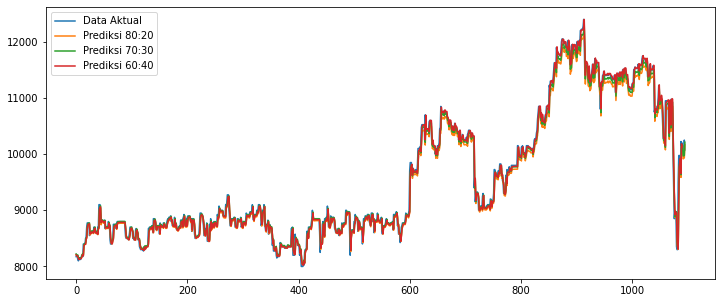

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_y[:1096])
plt.plot(cnn_train[:1096])
plt.plot(cnn_train_70[:1096])
plt.plot(cnn_train_60[:1096])
plt.legend(['Data Aktual', 'Prediksi 80:20', 'Prediksi 70:30', 'Prediksi 60:40'])

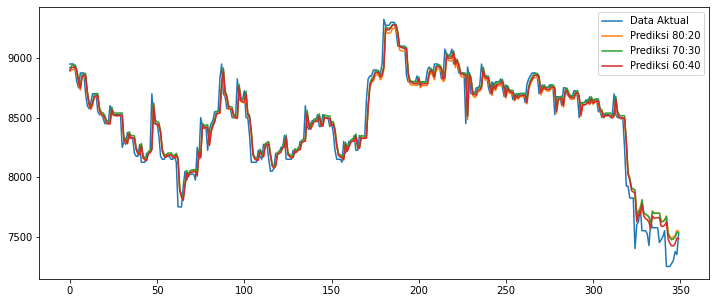

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[-350:])
plt.plot(cnn_test[-350:])
plt.plot(cnn_test_30[-350:])
plt.plot(cnn_test_40[-350:])
plt.legend(['Data Aktual', 'Prediksi 80:20', 'Prediksi 70:30', 'Prediksi 60:40'])

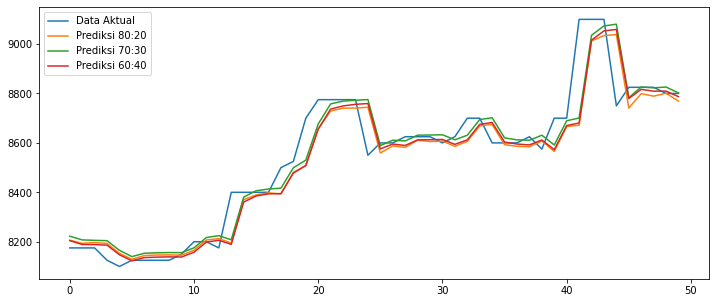

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_y[:50])
plt.plot(cnn_train[:50])
plt.plot(cnn_train_70[:50])
plt.plot(cnn_train_60[:50])
plt.legend(['Data Aktual', 'Prediksi 80:20', 'Prediksi 70:30', 'Prediksi 60:40'])

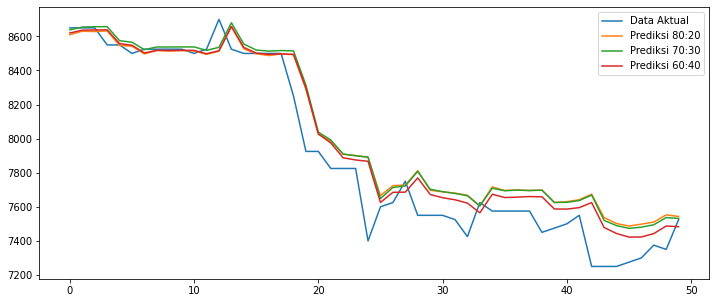

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[-50:])
plt.plot(cnn_test[-50:])
plt.plot(cnn_test_30[-50:])
plt.plot(cnn_test_40[-50:])
plt.legend(['Data Aktual', 'Prediksi 80:20', 'Prediksi 70:30', 'Prediksi 60:40'])

## BiLSTM

### Model

In [ ]:
def bilstm_builder(hp):
  model = Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units_lstm = hp.Int('units_lstm', min_value=32, max_value=512, step=32)
  model.add(Bidirectional(LSTM(hp_units_lstm, activation='relu', input_shape=(1, 5))))
  model.add(Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mse')

  return model

In [ ]:
bilstmtuner = kt.RandomSearch(bilstm_builder,
                     objective='val_loss',
                     max_trials=15,
                     seed=42,
                     executions_per_trial=2,
                     directory='/content/drive/MyDrive/Skripsweet/mse/icbp',
                     project_name='bi-lstm'
                    # # FOR TRAIN ONLY
                    #  overwrite=True
                    # # --------------
                     )

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Skripsweet/mse/icbp/bi-lstm/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Skripsweet/mse/icbp/bi-lstm/tuner0.json


In [ ]:
bilstmtuner.search(X_train, y_train, epochs=50, validation_split=0.2)

Trial 15 Complete [00h 01m 21s]
val_loss: 0.0006299819506239146

Best val_loss So Far: 0.0006260778463911265
Total elapsed time: 00h 19m 07s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hps=bilstmtuner.get_best_hyperparameters(num_trials=1)[0]

tuning = ['units_lstm', 'learning_rate']
print('Best tune:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune:
units_lstm: 320
learning_rate: 0.01


In [ ]:
bilstmtuner.results_summary(num_trials=15)

Results summary
Results in icbp/bi-lstm
Showing 15 best trials
Trial summary
Hyperparameters:
units_lstm: 320
learning_rate: 0.01
Score: 0.0006260778463911265
Trial summary
Hyperparameters:
units_lstm: 256
learning_rate: 0.01
Score: 0.000627219385933131
Trial summary
Hyperparameters:
units_lstm: 288
learning_rate: 0.01
Score: 0.0006280052766669542
Trial summary
Hyperparameters:
units_lstm: 416
learning_rate: 0.01
Score: 0.0006299819506239146
Trial summary
Hyperparameters:
units_lstm: 480
learning_rate: 0.01
Score: 0.0006310882745310664
Trial summary
Hyperparameters:
units_lstm: 64
learning_rate: 0.01
Score: 0.00063203094759956
Trial summary
Hyperparameters:
units_lstm: 352
learning_rate: 0.01
Score: 0.0006346528825815767
Trial summary
Hyperparameters:
units_lstm: 480
learning_rate: 0.001
Score: 0.0006557070882990956
Trial summary
Hyperparameters:
units_lstm: 448
learning_rate: 0.001
Score: 0.0006614016892854124
Trial summary
Hyperparameters:
units_lstm: 224
learning_rate: 0.001
Score: 

#### 80:20

In [ ]:
best_hp = bilstmtuner.get_best_hyperparameters()[0]
bilstm = bilstmtuner.hypermodel.build(best_hp)

# bilstm.summary()

In [ ]:
historybilstm = bilstm.fit(X_train, y_train, 
                       epochs=50,
                       validation_data=(X_test, y_test), 
                       verbose=2)

Epoch 1/50
46/46 - 4s - loss: 0.0161 - val_loss: 0.0013 - 4s/epoch - 97ms/step
Epoch 2/50
46/46 - 1s - loss: 0.0014 - val_loss: 8.7362e-04 - 770ms/epoch - 17ms/step
Epoch 3/50
46/46 - 1s - loss: 0.0013 - val_loss: 8.4150e-04 - 733ms/epoch - 16ms/step
Epoch 4/50
46/46 - 1s - loss: 0.0013 - val_loss: 9.1194e-04 - 707ms/epoch - 15ms/step
Epoch 5/50
46/46 - 1s - loss: 0.0012 - val_loss: 6.6256e-04 - 715ms/epoch - 16ms/step
Epoch 6/50
46/46 - 1s - loss: 0.0011 - val_loss: 5.9897e-04 - 724ms/epoch - 16ms/step
Epoch 7/50
46/46 - 1s - loss: 9.7602e-04 - val_loss: 7.5948e-04 - 740ms/epoch - 16ms/step
Epoch 8/50
46/46 - 1s - loss: 0.0010 - val_loss: 5.3861e-04 - 766ms/epoch - 17ms/step
Epoch 9/50
46/46 - 1s - loss: 8.9608e-04 - val_loss: 5.2382e-04 - 748ms/epoch - 16ms/step
Epoch 10/50
46/46 - 1s - loss: 9.2707e-04 - val_loss: 4.8186e-04 - 818ms/epoch - 18ms/step
Epoch 11/50
46/46 - 1s - loss: 9.3441e-04 - val_loss: 4.5766e-04 - 756ms/epoch - 16ms/step
Epoch 12/50
46/46 - 1s - loss: 7.9678e-04 -

In [ ]:
bilstm.save('bi_lstm.h5')

#### 70:30

In [ ]:
best_hp = bilstmtuner.get_best_hyperparameters()[0]
bilstm7030 = bilstmtuner.hypermodel.build(best_hp)

# bilstm.summary()

In [ ]:
historybilstm7030 = bilstm7030.fit(X_train_70, y_train_70, 
                       epochs=50,
                       validation_data=(X_test_30, y_test_30), 
                       verbose=2)

Epoch 1/50
40/40 - 4s - loss: 0.0170 - val_loss: 0.0011 - 4s/epoch - 90ms/step
Epoch 2/50
40/40 - 1s - loss: 0.0017 - val_loss: 8.5537e-04 - 592ms/epoch - 15ms/step
Epoch 3/50
40/40 - 1s - loss: 0.0014 - val_loss: 8.0456e-04 - 577ms/epoch - 14ms/step
Epoch 4/50
40/40 - 1s - loss: 0.0014 - val_loss: 7.6175e-04 - 569ms/epoch - 14ms/step
Epoch 5/50
40/40 - 1s - loss: 0.0013 - val_loss: 0.0010 - 571ms/epoch - 14ms/step
Epoch 6/50
40/40 - 1s - loss: 0.0012 - val_loss: 0.0011 - 582ms/epoch - 15ms/step
Epoch 7/50
40/40 - 1s - loss: 0.0012 - val_loss: 6.2600e-04 - 656ms/epoch - 16ms/step
Epoch 8/50
40/40 - 1s - loss: 0.0010 - val_loss: 7.3794e-04 - 699ms/epoch - 17ms/step
Epoch 9/50
40/40 - 1s - loss: 9.6509e-04 - val_loss: 6.1025e-04 - 634ms/epoch - 16ms/step
Epoch 10/50
40/40 - 1s - loss: 9.3012e-04 - val_loss: 6.3815e-04 - 607ms/epoch - 15ms/step
Epoch 11/50
40/40 - 1s - loss: 0.0013 - val_loss: 6.4130e-04 - 585ms/epoch - 15ms/step
Epoch 12/50
40/40 - 1s - loss: 9.7003e-04 - val_loss: 5.219

In [ ]:
bilstm7030.save('bi_lstm7030.h5')

#### 60:40

In [ ]:
best_hp = bilstmtuner.get_best_hyperparameters()[0]
bilstm6040 = bilstmtuner.hypermodel.build(best_hp)

# bilstm.summary()

In [ ]:
historybilstm6040 = bilstm6040.fit(X_train_60, y_train_60, 
                       epochs=50,
                       validation_data=(X_test_40, y_test_40), 
                       verbose=2)

Epoch 1/50
35/35 - 5s - loss: 0.0205 - val_loss: 0.0017 - 5s/epoch - 135ms/step
Epoch 2/50
35/35 - 1s - loss: 0.0015 - val_loss: 0.0011 - 680ms/epoch - 19ms/step
Epoch 3/50
35/35 - 1s - loss: 0.0013 - val_loss: 0.0010 - 675ms/epoch - 19ms/step
Epoch 4/50
35/35 - 1s - loss: 0.0014 - val_loss: 0.0011 - 709ms/epoch - 20ms/step
Epoch 5/50
35/35 - 1s - loss: 0.0013 - val_loss: 9.5264e-04 - 661ms/epoch - 19ms/step
Epoch 6/50
35/35 - 1s - loss: 0.0011 - val_loss: 9.1864e-04 - 664ms/epoch - 19ms/step
Epoch 7/50
35/35 - 1s - loss: 0.0012 - val_loss: 9.1940e-04 - 660ms/epoch - 19ms/step
Epoch 8/50
35/35 - 1s - loss: 0.0011 - val_loss: 0.0012 - 700ms/epoch - 20ms/step
Epoch 9/50
35/35 - 1s - loss: 0.0011 - val_loss: 9.0729e-04 - 692ms/epoch - 20ms/step
Epoch 10/50
35/35 - 1s - loss: 9.9953e-04 - val_loss: 7.7722e-04 - 639ms/epoch - 18ms/step
Epoch 11/50
35/35 - 1s - loss: 8.8060e-04 - val_loss: 0.0011 - 644ms/epoch - 18ms/step
Epoch 12/50
35/35 - 1s - loss: 0.0012 - val_loss: 8.4557e-04 - 660ms/e

In [ ]:
bilstm6040.save('bi_lstm6040.h5')

### Evaluation

In [ ]:
from keras.models import load_model

bilstm = load_model("/content/drive/MyDrive/Skripsweet/mse/bi_lstm/bi_lstm.h5")
bilstm7030 = load_model("/content/drive/MyDrive/Skripsweet/mse/bi_lstm/bi_lstm7030.h5")
bilstm6040 = load_model("/content/drive/MyDrive/Skripsweet/mse/bi_lstm/bi_lstm6040.h5")

In [ ]:
def metrics_evaluation_regression(test, predict):
  metrics = pd.DataFrame({
      'R2': [r2_score(test, predict)],
      'MSE': [mean_squared_error(test, predict)],
      'RMSE': [np.sqrt(mean_squared_error(test, predict))],
      'MAE': [mean_absolute_error(test, predict)],
      'MAPE': [mean_absolute_percentage_error(test, predict)]
  })
  return metrics

80:20

In [ ]:
train_predict = bilstm.predict(X_train)
test_predict = bilstm.predict(X_test)

In [ ]:
metrics_evaluation_regression(y_train, train_predict)

,R2,MSE,RMSE,MAE,MAPE
0,0.978068,0.000892,0.029867,0.021773,0.052314


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([y_test])

In [ ]:
metrics_evaluation_regression(train_y[0], train_predict)

,R2,MSE,RMSE,MAE,MAPE
0,0.978068,23659.034866,153.814937,112.132909,0.011554


In [ ]:
metrics_evaluation_regression(test_y[0], test_predict)

,R2,MSE,RMSE,MAE,MAPE
0,0.884571,19548.011951,139.814205,94.354353,0.011409


70:30

In [ ]:
train_predict_70 = bilstm7030.predict(X_train_70)
test_predict_30 = bilstm7030.predict(X_test_30)

In [ ]:
metrics_evaluation_regression(y_train_70, train_predict_70)

,R2,MSE,RMSE,MAE,MAPE
0,0.98414,0.000712,0.026678,0.015553,0.04009


In [ ]:
train_predict_70 = scaler.inverse_transform(train_predict_70)
train_y_70 = scaler.inverse_transform([y_train_70])
test_predict_30 = scaler.inverse_transform(test_predict_30)
test_y_30 = scaler.inverse_transform([y_test_30])

In [ ]:
metrics_evaluation_regression(train_y_70[0], train_predict_70)

,R2,MSE,RMSE,MAE,MAPE
0,0.98414,18875.815094,137.389283,80.096052,0.008351


In [ ]:
metrics_evaluation_regression(test_y_30[0], test_predict_30)

,R2,MSE,RMSE,MAE,MAPE
0,0.959068,16195.337416,127.260903,79.379095,0.009258


60:40

In [ ]:
train_predict_60 = bilstm6040.predict(X_train_60)
test_predict_40 = bilstm6040.predict(X_test_40)

In [ ]:
metrics_evaluation_regression(y_train_60, train_predict_60)

,R2,MSE,RMSE,MAE,MAPE
0,0.986348,0.000685,0.026169,0.016288,0.042055


In [ ]:
train_predict_60 = scaler.inverse_transform(train_predict_60)
train_y_60 = scaler.inverse_transform([y_train_60])
test_predict_40 = scaler.inverse_transform(test_predict_40)
test_y_40 = scaler.inverse_transform([y_test_40])

In [ ]:
train_y_60.shape

(1, 1090)

In [ ]:
metrics_evaluation_regression(train_y_60[0], train_predict_60)

,R2,MSE,RMSE,MAE,MAPE
0,0.986348,18162.529966,134.768431,83.880891,0.008741


In [ ]:
metrics_evaluation_regression(test_y_40[0], test_predict_40)

,R2,MSE,RMSE,MAE,MAPE
0,0.966744,17457.651518,132.127406,85.975445,0.009625


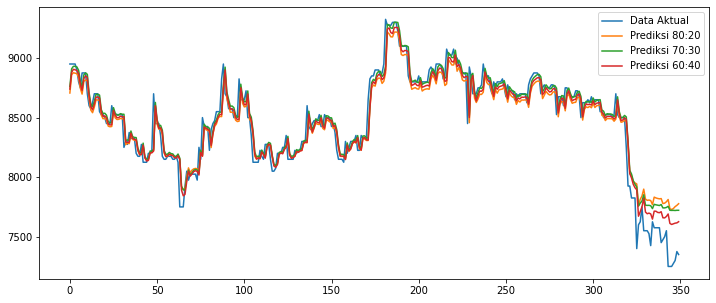

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[0][-350:])
plt.plot(test_predict[-350:])
plt.plot(test_predict_30[-350:])
plt.plot(test_predict_40[-350:])
plt.legend(['Data Aktual', 'Prediksi 80:20', 'Prediksi 70:30', 'Prediksi 60:40'])

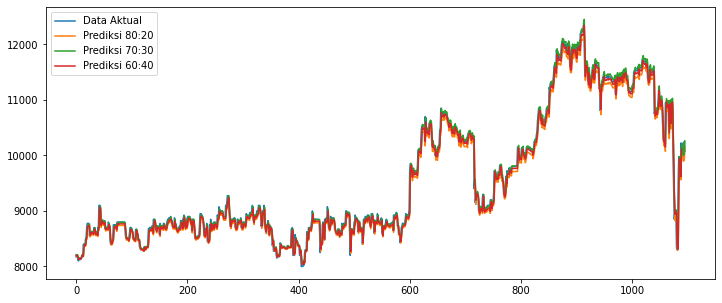

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_y[0][:1096])
plt.plot(train_predict[:1096])
plt.plot(train_predict_70[:1096])
plt.plot(train_predict_60)
plt.legend(['Data Aktual', 'Prediksi 80:20', 'Prediksi 70:30', 'Prediksi 60:40'])

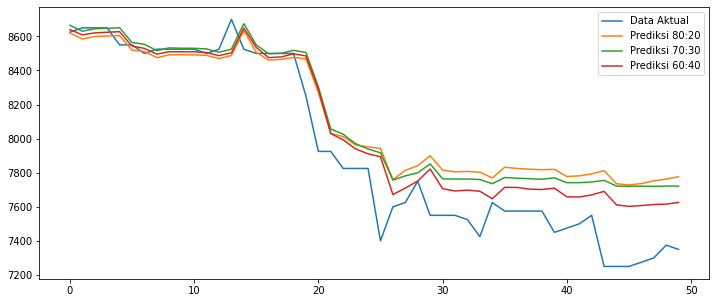

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[0][-50:])
plt.plot(test_predict[-50:])
plt.plot(test_predict_30[-50:])
plt.plot(test_predict_40[-50:])
plt.legend(['Data Aktual', 'Prediksi 80:20', 'Prediksi 70:30', 'Prediksi 60:40'])

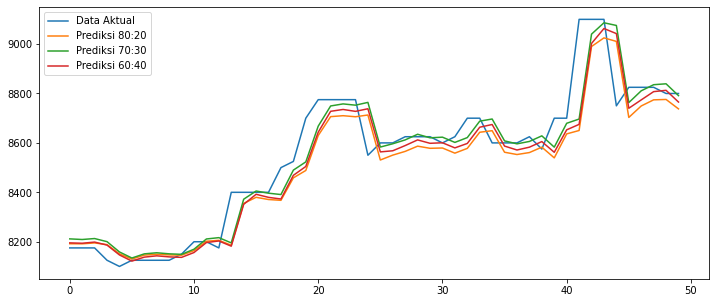

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_y[0][:50])
plt.plot(train_predict[:50])
plt.plot(train_predict_70[:50])
plt.plot(train_predict_60[:50])
plt.legend(['Data Aktual', 'Prediksi 80:20', 'Prediksi 70:30', 'Prediksi 60:40'])

### Old Eval

In [ ]:
train_predict2 = bilstm.predict(X_train)
test_predict2 = bilstm.predict(X_test)

train_predict2 = scaler.inverse_transform(train_predict2)
# train_y = scaler.inverse_transform([y_train])
test_predict2 = scaler.inverse_transform(test_predict2)
# test_y = scaler.inverse_transform([y_test])

In [ ]:
def metrics_evaluation_regression(test, predict):
  metrics = pd.DataFrame({
      'MSE': [mean_squared_error(test, predict)],
      'RMSE': [np.sqrt(mean_squared_error(test, predict))],
      'MAE': [mean_absolute_error(test, predict)],
      'MAPE': [mean_absolute_percentage_error(test, predict)]
  })
  return metrics 

In [ ]:
metrics_evaluation_regression(train_y[0], train_predict2)

,MSE,RMSE,MAE,MAPE
0,26931.047769,164.106818,124.839657,0.012824


In [ ]:
metrics_evaluation_regression(train_y[0], train_predict2)

,MSE,RMSE,MAE,MAPE
0,26931.047769,164.106818,124.839657,0.012824


In [ ]:
metrics_evaluation_regression(test_y[0], test_predict2)

,MSE,RMSE,MAE,MAPE
0,19136.665756,138.335338,98.103473,0.011776


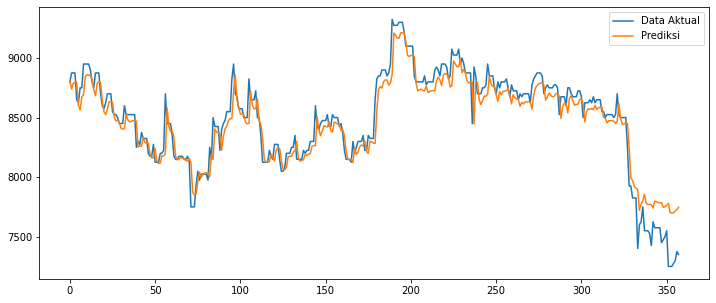

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[0])
plt.plot(test_predict2)
plt.legend(['Data Aktual', 'Prediksi'])

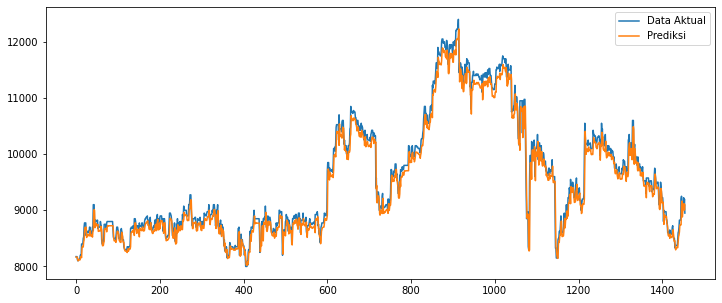

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_y[0])
plt.plot(train_predict2)
plt.legend(['Data Aktual', 'Prediksi'])

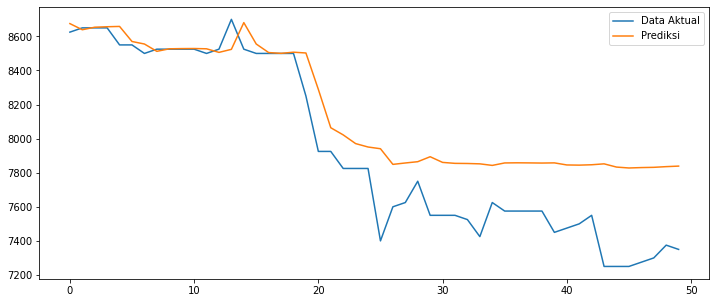

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[0][-50:])
plt.plot(test_predict2[-50:])
plt.legend(['Data Aktual', 'Prediksi'])

# Perbandingan

## Vanilla

In [ ]:
metrics_evaluation_regression(train_y[0], train_predict)

,MSE,RMSE,MAE,MAPE
0,22317.417773,149.390153,100.44915,0.010407


In [ ]:
metrics_evaluation_regression(test_y[0], test_predict)

,MSE,RMSE,MAE,MAPE
0,14976.625376,122.379023,87.167432,0.010493


## CNN-LSTM

In [ ]:
metrics_evaluation_regression(y_train2, lstmcnn.predict(X_train2))

,MSE,RMSE,MAE,MAPE
0,19680.56353,140.287432,84.143688,0.008833


In [ ]:
metrics_evaluation_regression(y_test2, lstmcnn.predict(X_test2))

,MSE,RMSE,MAE,MAPE
0,11903.910186,109.105042,71.649232,0.008518


## BiLSTM

In [ ]:
metrics_evaluation_regression(train_y[0], train_predict2)

,MSE,RMSE,MAE,MAPE
0,17973.617383,134.06572,78.633088,0.008204


In [ ]:
metrics_evaluation_regression(test_y[0], test_predict2)

,MSE,RMSE,MAE,MAPE
0,11413.950255,106.836091,67.162503,0.008017


## Chart 

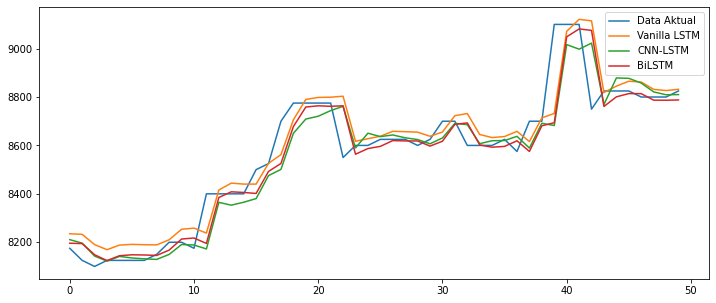

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_y[0][:50])
plt.plot(train_predict[:50])
plt.plot(cnn_train[:50])
plt.plot(train_predict2[:50])
plt.legend(['Data Aktual', 'Vanilla LSTM', 'CNN-LSTM', 'BiLSTM'])

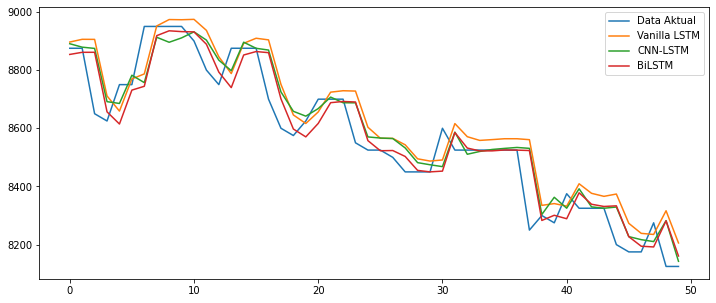

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[0][:50])
plt.plot(test_predict[:50])
plt.plot(cnn_test[:50])
plt.plot(test_predict2[:50])
plt.legend(['Data Aktual', 'Vanilla LSTM', 'CNN-LSTM', 'BiLSTM'])

In [ ]:
trace1 = go.Scatter(
    x = weekly_rows['Date'],
    y = test_y[0].astype(float),
    mode = 'lines',
    name = 'Data Aktual'
)

trace2 = go.Scatter(
    x = weekly_rows['Date'],
    y = np.ravel(test_predict).astype(float),
    mode = 'lines',
    name = 'Vanilla LSTM'
)

trace3 = go.Scatter(
    x = weekly_rows['Date'],
    y = np.ravel(cnn_test).astype(float),
    mode = 'lines',
    name = 'CNN-LSTM'
)

trace4 = go.Scatter(
    x = weekly_rows['Date'],
    y = np.ravel(test_predict2).astype(float),
    mode = 'lines',
    name = 'Bi-LSTM'
)

layout = dict(
    title='ICBP Prices Test Prediction (2017-2022) with the Slider ',
    hovermode='x',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

# data = [trace1,trace2, trace3]
data = [trace1,trace2,trace3,trace4]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")
# fig.show()

# Visualisasi

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 5.2 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
def model_builder(hp):
  n_steps, n_features = 7, 1
  model = Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_filter = hp.Int('units_filter', min_value=8, max_value=512, step=32)
  hp_units_lstm = hp.Int('units_lstm', min_value=8, max_value=512, step=32)
  hp_units_dense = hp.Int('units_dense', min_value=8, max_value=512, step=32)
  model.add(Reshape((n_steps, n_features), input_dim=n_steps))
  model.add(Conv1D(filters=hp_filter, kernel_size=2, activation='relu'))
  model.add(LSTM(hp_units_lstm, activation='relu'))
  model.add(Dense(hp_units_dense, activation='relu'))
  model.add(Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mse')

  return model

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
n_steps, n_features = 7, 1
X, y = input_output_split_sequence(ts, n_steps)

tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='cnn-lstm_model',
                     project_name='during_covid',
                    # # FOR TRAIN ONLY
                    #  overwrite=True
                    # # --------------
                     )

tuner.search(X, y, epochs=50, callbacks=[stop_early], validation_split=0.2,)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

tuning = ['units_filter', 'units_lstm', 'units_dense', 'learning_rate']
print('Best tune:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune:
units_filter: 72
units_lstm: 296
units_dense: 296
learning_rate: 0.01


## Skenario Penelitian

**Hyperparameter:** dari Hyperband atau RandomSearch untuk masing-masing arsitektur

**Epoch:** Jumlah epoch kelipatan 50 (3-5 jenis epoch)

**Time Steps:** 5 jenis(?) dengan epoch yg terbaik untuk masing2 arsitektur.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import load_model

bilstm7030 = load_model("/content/drive/MyDrive/Skripsweet/mse/bi_lstm/bi_lstm7030.h5")

lstmcnn7030 = load_model("/content/drive/MyDrive/Skripsweet/mse/cnn_lstm/cnn_lstm7030.h5")
lstmcnn6040 = load_model("/content/drive/MyDrive/Skripsweet/mse/cnn_lstm/cnn_lstm6040.h5")

lstm7030 = load_model("/content/drive/MyDrive/Skripsweet/mse/vanilla_lstm/vanilla_lstm7030.h5")

In [ ]:
lstm7030.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 416)               702208    
                                                                 
 dense_2 (Dense)             (None, 1)                 417       
                                                                 
Total params: 702,625
Trainable params: 702,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 5.3 MB/s 


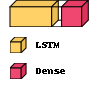

In [ ]:
# Export bentuk arsitektur dalam bentuk lebih visual
import visualkeras
visualkeras.layered_view(lstm7030, legend=True)

In [ ]:
import tensorflow as tf

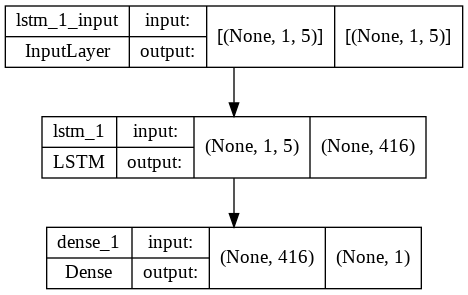

In [ ]:
dot_img_file = '/content/model_1.png'
tf.keras.utils.plot_model(lstm7030, to_file=dot_img_file, show_shapes=True)

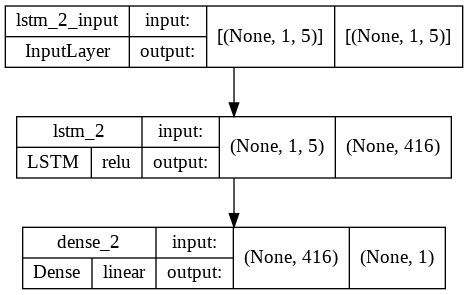

In [ ]:
dot_img_file = '/content/model_1.png'
tf.keras.utils.plot_model(lstm7030, to_file=dot_img_file, show_shapes=True, show_layer_activations=True)

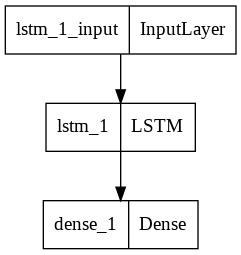

In [ ]:
tf.keras.utils.plot_model(lstm7030)

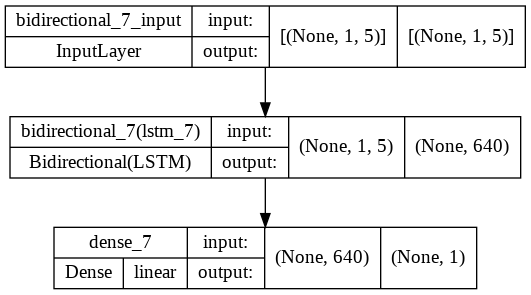

In [ ]:
tf.keras.utils.plot_model(bilstm7030, show_shapes=True, show_layer_activations=True)

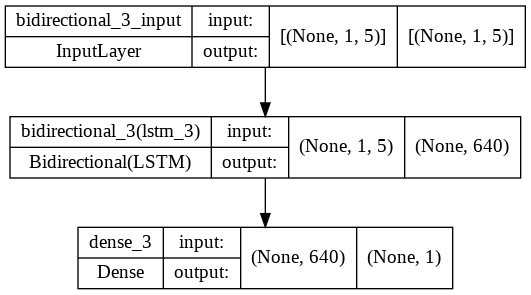

In [ ]:
tf.keras.utils.plot_model(bilstm7030, show_shapes=True)

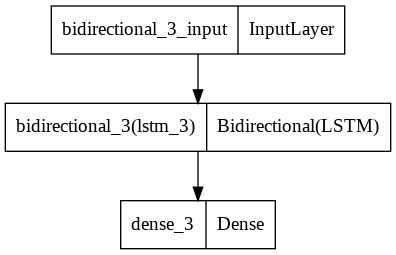

In [ ]:
tf.keras.utils.plot_model(bilstm7030)

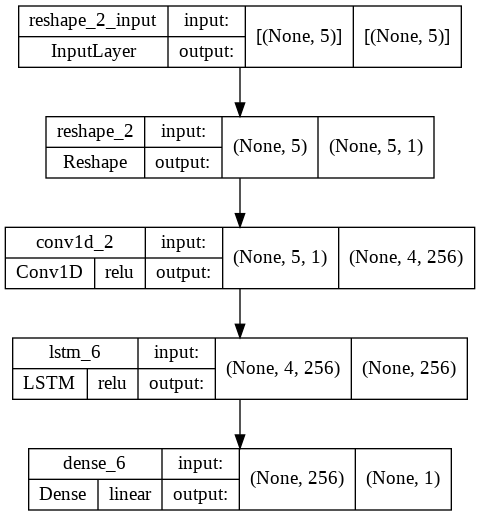

In [ ]:
tf.keras.utils.plot_model(lstmcnn7030, show_shapes=True, show_layer_activations=True)

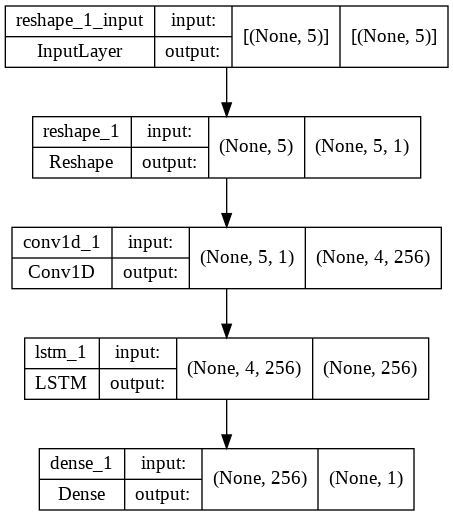

In [ ]:
tf.keras.utils.plot_model(lstmcnn7030, show_shapes=True)

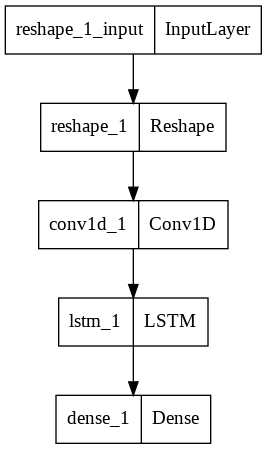

In [ ]:
tf.keras.utils.plot_model(lstmcnn7030)

# Evaluasi

In [ ]:
def metrics_evaluation_regression(test, predict):
  metrics = pd.DataFrame({
      'R2': [r2_score(test, predict)],
      'MSE': [mean_squared_error(test, predict)],
      'RMSE': [np.sqrt(mean_squared_error(test, predict))],
      'MAE': [mean_absolute_error(test, predict)],
      'MAPE': [mean_absolute_percentage_error(test, predict)]
  })
  return metrics

In [ ]:
from keras.models import load_model

bilstm7030 = load_model("/content/drive/MyDrive/Skripsweet/mse/bi_lstm/bi_lstm7030.h5")

lstmcnn7030 = load_model("/content/drive/MyDrive/Skripsweet/mse/cnn_lstm/cnn_lstm7030.h5")
lstmcnn6040 = load_model("/content/drive/MyDrive/Skripsweet/mse/cnn_lstm/cnn_lstm6040.h5")

lstm7030 = load_model("/content/drive/MyDrive/Skripsweet/mse/vanilla_lstm/vanilla_lstm7030.h5")

In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 648 kB/s 
     |████████████████████████████████| 133 kB 10.5 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=09fd81f6aa37c0956791d229dab7f4e335389774765d5dafd252d7cc54a0fbe5
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is inco

## 70:30

In [ ]:
X_test2_30_reduce = np.squeeze(X_test2_30)
y_test2_30_reduce = np.squeeze(y_test2_30)

In [ ]:
X_test2_30_reduce.shape

(541, 5)

Weight tuh seberapa besar pengaruh suatu feature terhadap performa model, misal scoringnya r2, trus weight nya 00122 +- 0.001 itu berarti feature tersebut menurunkan nilai r2 sebesar 0.0122 hingga 0.001 ketika feature tersebut diacak nilainya.

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(lstmcnn7030, scoring="neg_mean_absolute_error", random_state=11).fit(X_test2_30_reduce,y_test2_30_reduce)
eli5.show_weights(perm, feature_names = [f'X-{i+1}' for i in range(5)])

Weight,Feature
0.0935 ± 0.0038,X-5
0.0073 ± 0.0011,X-4
0.0023 ± 0.0005,X-3
0.0004 ± 0.0001,X-1
0.0002 ± 0.0001,X-2


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(lstmcnn7030, scoring="r2", random_state=11).fit(X_test2_30_reduce,y_test2_30_reduce)
eli5.show_weights(perm, feature_names = [f'X-{i+1}' for i in range(5)])

Weight,Feature
1.1740 ± 0.0654,X-5
0.0311 ± 0.0071,X-4
0.0071 ± 0.0019,X-3
0.0006 ± 0.0002,X-1
0.0003 ± 0.0003,X-2


## 60:40

In [ ]:
X_test2_40_reduce = np.squeeze(X_test2_40)
y_test2_40_reduce = np.squeeze(y_test2_40)

In [ ]:
X_test2_40_reduce.shape

(724, 5)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(lstmcnn6040, scoring="r2", random_state=11).fit(X_test2_40_reduce,y_test2_40_reduce)
eli5.show_weights(perm, feature_names = [f'X-{i+1}' for i in range(5)])

Weight,Feature
1.1094 ± 0.1185,X-5
0.0355 ± 0.0074,X-4
0.0113 ± 0.0016,X-3
0.0022 ± 0.0011,X-2
0.0003 ± 0.0003,X-1


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(lstmcnn6040, scoring="neg_mean_absolute_error", random_state=11).fit(X_test2_40_reduce,y_test2_40_reduce)
eli5.show_weights(perm, feature_names = [f'X-{i+1}' for i in range(5)])

Weight,Feature
0.1095 ± 0.0081,X-5
0.0097 ± 0.0008,X-4
0.0047 ± 0.0005,X-3
0.0014 ± 0.0003,X-2
0.0003 ± 0.0001,X-1
